In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')

train['dataset'] = 'train'
test['dataset'] = 'test'

df = pd.concat([train, test])

## Overview of data

**train_features.csv**: Features for the training set. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

**test_features.csv**: Features for the test data. You must predict the probability of each scored MoA for each row in the test data.

In [5]:
df

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0     id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1     id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2     id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3     id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4     id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   
...            ...     ...      ...     ...     ...     ...     ...     ...   
3977  id_ff7004b87  trt_cp       24      D1  0.4571 -0.5743  3.3930 -0.6202   
3978  id_ff925dd0d  trt_cp       24      D1 -0.5885 -0.2548  2.5850  0.3456   
3979  id_ffb710450  trt_cp       72      D1 -0.3985 -0.1554  0.2677 -0.6813   
3980  id_ffbb869f2  trt_cp       48      D2 -1.0960 -1.7750 -0.3977  1.0160   
3981  id_ffd5800b6  trt_cp       72      D1 -0.5174  0.2953  0.3286 -0.0428   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584 -0.3981   
1     1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899  0.1522   
2    -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174 -0.6417   
3     4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880 -1.6210   
4     1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031  0.1094   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
3977  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791 -1.2680   
3978  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730  0.2614   
3979  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666  0.0461   
3980 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286 -0.2618   
3981 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041 -0.4948   

        c-97    c-98    c-99  dataset  
0     0.2139  0.3801  0.4176    train  
1     0.1241  0.6077  0.7371    train  
2    -0.2187 -1.4080  0.6931    train  
3    -0.8784 -0.3876 -0.8154    train  
4     0.2885 -0.3786  0.7125    train  
...      ...     ...     ...      ...  
3977 -1.1280 -0.4167 -0.6600     test  
3978 -0.2790 -0.0131 -0.0934     test  
3979  0.5888 -0.4205 -0.1504     test  
3980  0.5074  0.7430 -0.0484     test  
3981  0.0757 -0.1356  0.5280     test  

[27796 rows x 877 columns]

In [6]:
print('Number of rows in training set:', train.shape[0])
print('Number of columns in training set:', train.shape[1] - 1)

print('Number of rows in test set:', test.shape[0])
print('Number of columns in test set:', test.shape[1] - 1)

Number of rows in training set: 23814
Number of columns in training set: 876
Number of rows in test set: 3982
Number of columns in test set: 876


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27796 entries, 0 to 3981
Columns: 877 entries, sig_id to dataset
dtypes: float64(872), int64(1), object(4)
memory usage: 186.2+ MB


## Categories Visualization

In [8]:
width = 500
height = 400

In [9]:
ds = df.groupby(['cp_type', 'dataset'])['sig_id'].count().reset_index()
ds.columns = [
    'cp_type', 
    'dataset', 
    'count'
]

fig = px.bar(
    ds, 
    x='cp_type', 
    y="count", 
    color='dataset',
    orientation='v', 
    title='cp_type train/test counts', 
    width=width,
    height=height
)

fig.show()

In [10]:
ds = df.groupby(['cp_dose', 'dataset'])['sig_id'].count().reset_index()
ds.columns = [
    'cp_dose', 
    'dataset', 
    'count'
]

fig = px.bar(
    ds, 
    x='cp_dose', 
    y="count", 
    color='dataset',
    orientation='v', 
    title='cp_dose train/test counts', 
    width=width,
    height=height
)

fig.show()

## Gene and cell distributions

In [11]:
g_list = [
    i for i in train.columns.to_list() if i.startswith('g-')
]

c_list = [
    i for i in train.columns.to_list() if i.startswith('c-')
]

In [12]:
def plot_set_histograms(plot_list, title):
    fig = make_subplots(rows=6, cols=2)
    traces = [
        go.Histogram(
            x=train[col], 
            nbinsx=100, 
            name=col
        ) for col in plot_list
    ]

    for i in range(len(traces)):
        fig.append_trace(
            traces[i], 
            (i // 2) + 1, 
            (i % 2) + 1
        )

    fig.update_layout(
        title_text=title,
        height=1000,
        width=800
    )
    fig.show()

In [13]:
plot_list = [
    g_list[
        np.random.randint(0, len(g_list)-1)
    ] for i in range(10)
]

plot_list = list(set(plot_list))
plot_set_histograms(plot_list, 'Randomly selected gene expression features distributions')

In [14]:
plot_list = [
    c_list[
        np.random.randint(0, len(c_list)-1)
    ] for i in range(10)
]

plot_list = list(set(plot_list))
plot_set_histograms(plot_list, 'Randomly selected cell expression features distributions')

## Correlation

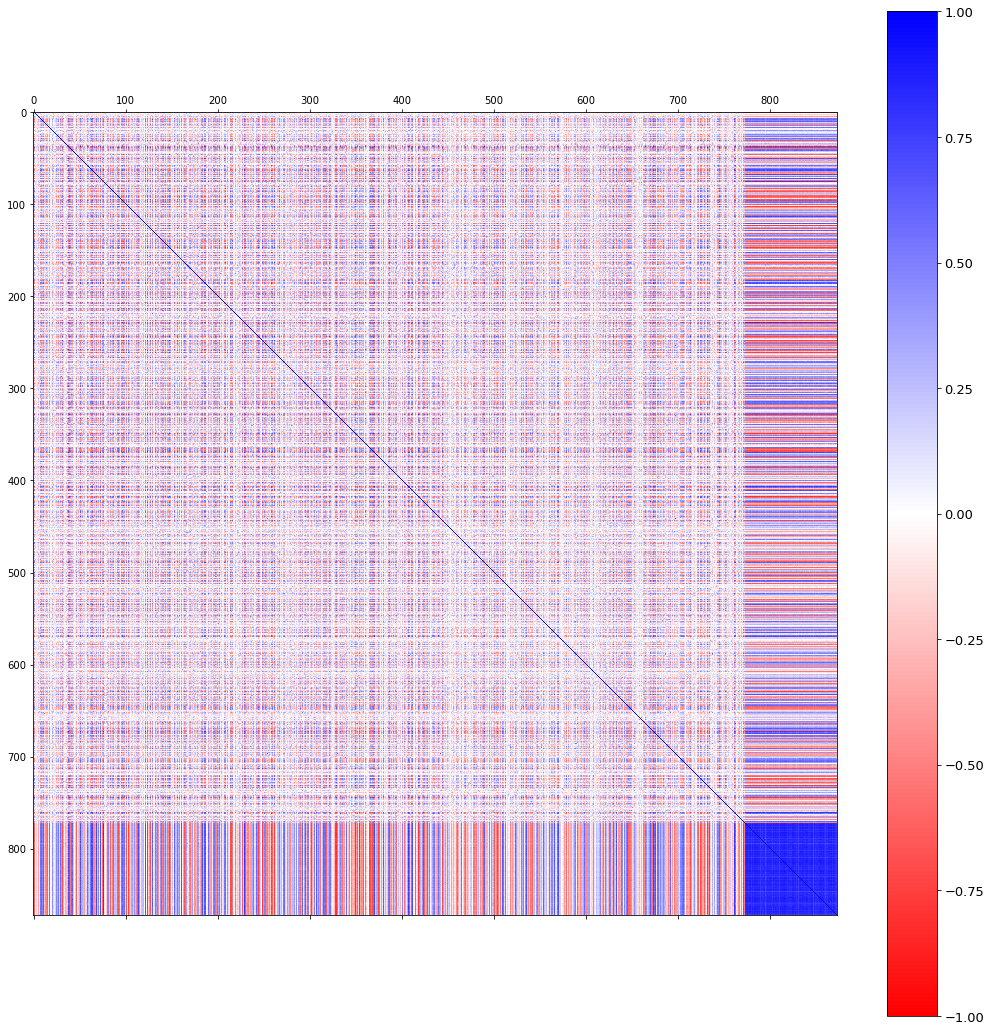

In [22]:
ds = df

fig = plt.figure(
    figsize=(18, 18)
)

plt.matshow(
    ds.corr()
    , fignum=fig.number
    , cmap="bwr_r"
    , vmin=-1
    , vmax=1
)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=13)

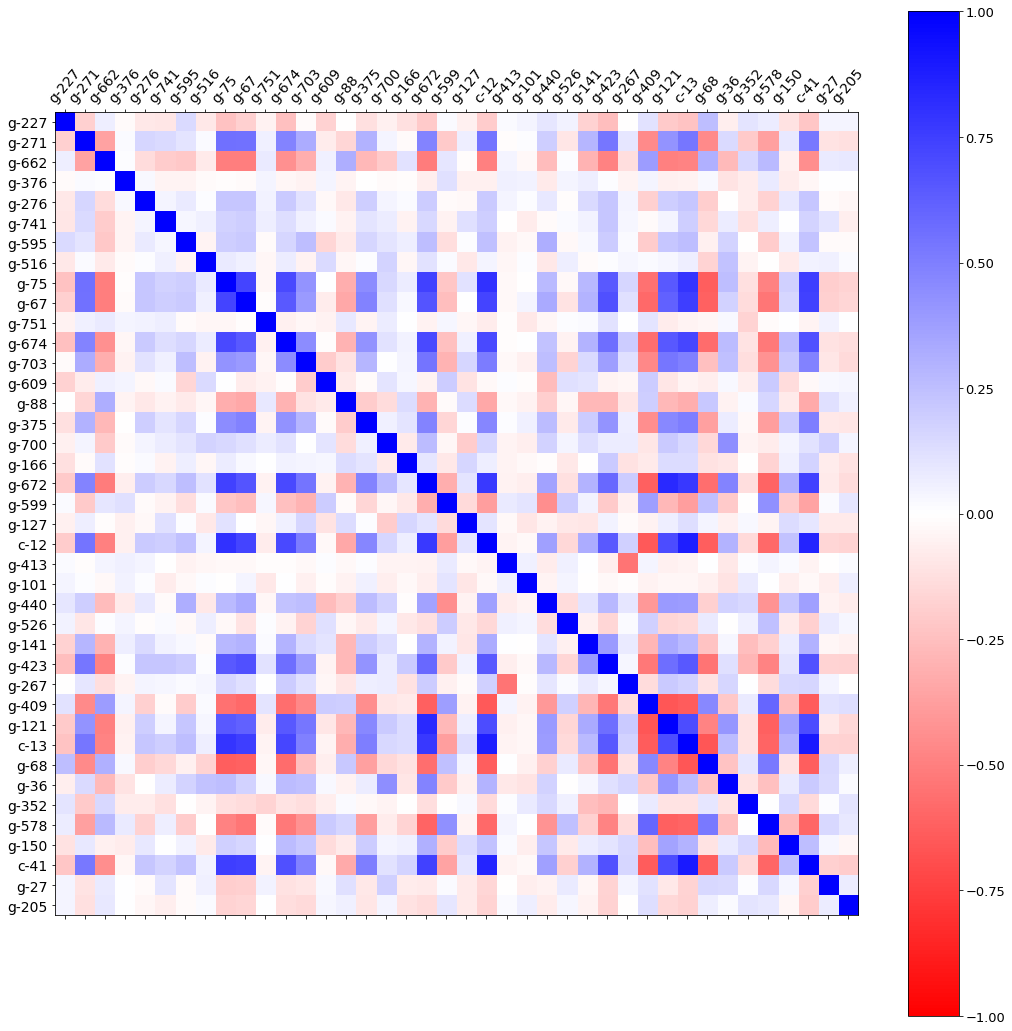

In [23]:
columns = g_list + c_list
sample = list(set([columns[np.random.randint(0, len(columns)-1)] for i in range(150)]))[:40]
ds = df[sample]

fig = plt.figure(
    figsize=(18, 18)
)

plt.matshow(
    ds.corr()
    , fignum=fig.number
    , cmap="bwr_r"
    , vmin=-1
    , vmax=1
)

plt.xticks(range(ds.shape[1]), ds.columns, fontsize=14, rotation=50)
plt.yticks(range(ds.shape[1]), ds.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=13)

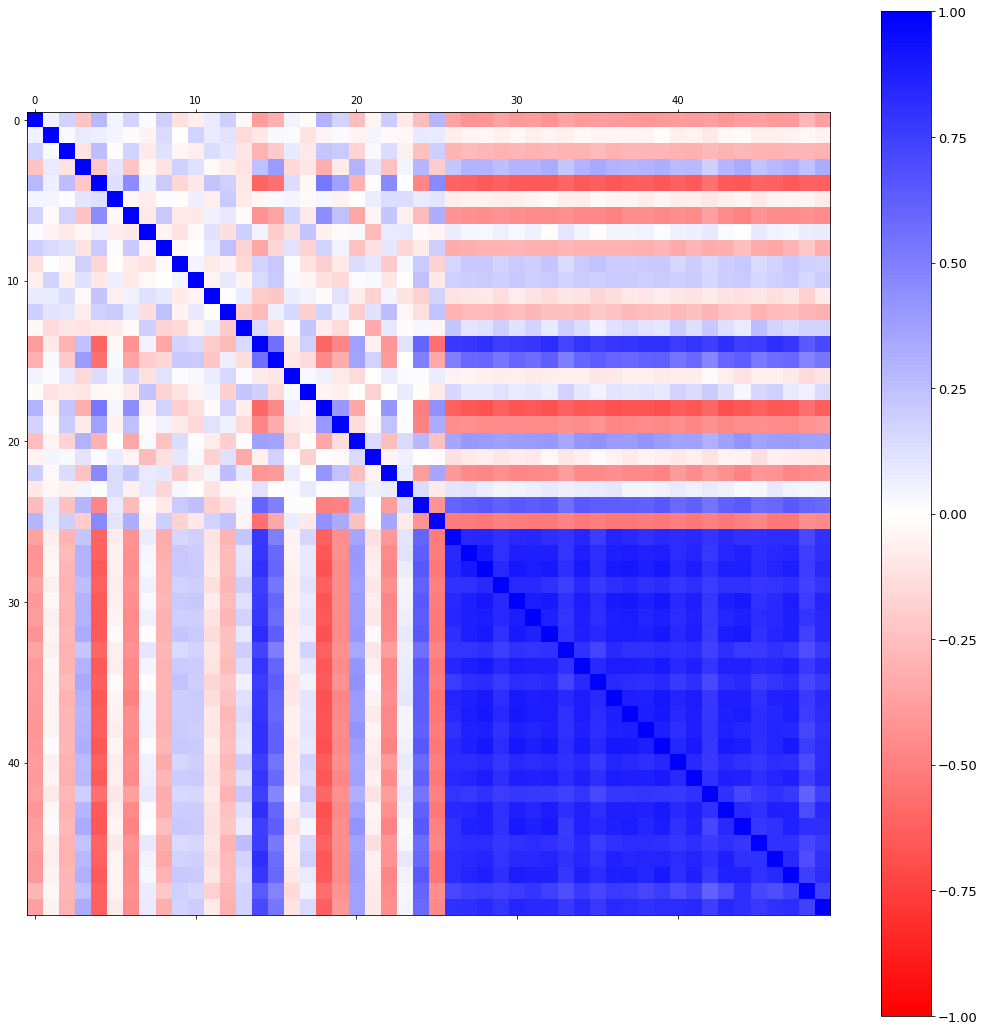

In [25]:
ds = df.iloc[:,750:800]

fig = plt.figure(
    figsize=(18, 18)
)

plt.matshow(
    ds.corr()
    , fignum=fig.number
    , cmap="bwr_r"
    , vmin=-1
    , vmax=1
)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=13)

In [ ]:
print()"corr = df.corr().abs()"

## Preprocess

In [13]:
def preprocess(df):
    df.cp_type = df.cp_type.astype('category')
    df.cp_dose = df.cp_dose.astype('category')
    return df

In [15]:
df = preprocess(df)